# Program 6: Implementation of MLP and RBF Network

**Objective:**
1. Build a BPN (Backpropagation Network) classifier
2. Build an RBF (Radial Basis Function) classifier
3. Compare the results

**Dataset:** Paper Reviews from UCI Machine Learning Repository

## Step 1: Import Required Libraries

In [31]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Load and Explore the Dataset

The Paper Reviews dataset contains reviews of conference papers with various features.

In [32]:
# Load the local reviews.json dataset
import json

print("Loading reviews.json dataset...")
with open('reviews.json', 'r') as f:
    data = json.load(f)

print(f"Dataset loaded successfully!")
print(f"Total number of papers: {len(data['paper'])}")

# Explore the structure
print("\nDataset structure:")
sample_paper = data['paper'][0]
print(f"Sample paper keys: {sample_paper.keys()}")
print(f"Sample review keys: {sample_paper['review'][0].keys()}")
print(f"\nFirst paper ID: {sample_paper['id']}")
print(f"Preliminary decision: {sample_paper['preliminary_decision']}")
print(f"Number of reviews: {len(sample_paper['review'])}")

Loading reviews.json dataset...
Dataset loaded successfully!
Total number of papers: 172

Dataset structure:
Sample paper keys: dict_keys(['id', 'preliminary_decision', 'review'])
Sample review keys: dict_keys(['confidence', 'evaluation', 'id', 'lan', 'orientation', 'remarks', 'text', 'timespan'])

First paper ID: 1
Preliminary decision: accept
Number of reviews: 3


In [33]:
# Process the JSON data and create a structured dataset
# We'll extract features from reviews and use preliminary_decision as target

print("Processing JSON data into structured format...")
processed_data = []

for paper in data['paper']:
    paper_id = paper['id']
    decision = paper['preliminary_decision']
    
    # Aggregate review features for each paper
    reviews = paper['review']
    
    # Calculate aggregate features from all reviews (handling None values)
    confidences = [int(r['confidence']) for r in reviews if r['confidence'] is not None]
    evaluations = [int(r['evaluation']) for r in reviews if r['evaluation'] is not None]
    orientations = [int(r['orientation']) for r in reviews if r['orientation'] is not None]
    
    # Skip papers with no valid reviews
    if not confidences or not evaluations or not orientations:
        continue
    
    # Aggregate statistics
    row = {
        'paper_id': paper_id,
        'num_reviews': len(reviews),
        'avg_confidence': np.mean(confidences),
        'max_confidence': np.max(confidences),
        'min_confidence': np.min(confidences),
        'std_confidence': np.std(confidences) if len(confidences) > 1 else 0,
        'avg_evaluation': np.mean(evaluations),
        'max_evaluation': np.max(evaluations),
        'min_evaluation': np.min(evaluations),
        'std_evaluation': np.std(evaluations) if len(evaluations) > 1 else 0,
        'avg_orientation': np.mean(orientations),
        'positive_orientations': sum(1 for o in orientations if o == 1),
        'negative_orientations': sum(1 for o in orientations if o == 0),
        'decision': decision
    }
    processed_data.append(row)

# Create DataFrame
df = pd.DataFrame(processed_data)

print(f"Processed dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

Processing JSON data into structured format...
Processed dataset shape: (169, 14)

First few rows:
   paper_id  num_reviews  avg_confidence  max_confidence  min_confidence  \
0         1            3        4.333333               5               4   
1         2            3        4.000000               4               4   
2         3            3        3.333333               4               3   
3         4            2        3.000000               4               2   
4         5            3        4.333333               5               4   

   std_confidence  avg_evaluation  max_evaluation  min_evaluation  \
0        0.471405        1.000000               1               1   
1        0.000000        2.000000               2               2   
2        0.471405        1.333333               2               0   
3        1.000000        0.000000               2              -2   
4        0.471405        2.000000               2               2   

   std_evaluation  avg_orient

## Step 3: Data Preprocessing

We'll check the data quality and prepare it for classification.

Missing Values:
paper_id                 0
num_reviews              0
avg_confidence           0
max_confidence           0
min_confidence           0
std_confidence           0
avg_evaluation           0
max_evaluation           0
min_evaluation           0
std_evaluation           0
avg_orientation          0
positive_orientations    0
negative_orientations    0
decision                 0
dtype: int64

Class Distribution (Preliminary Decision):
decision
accept             113
reject              48
probably reject      7
no decision          1
Name: count, dtype: int64


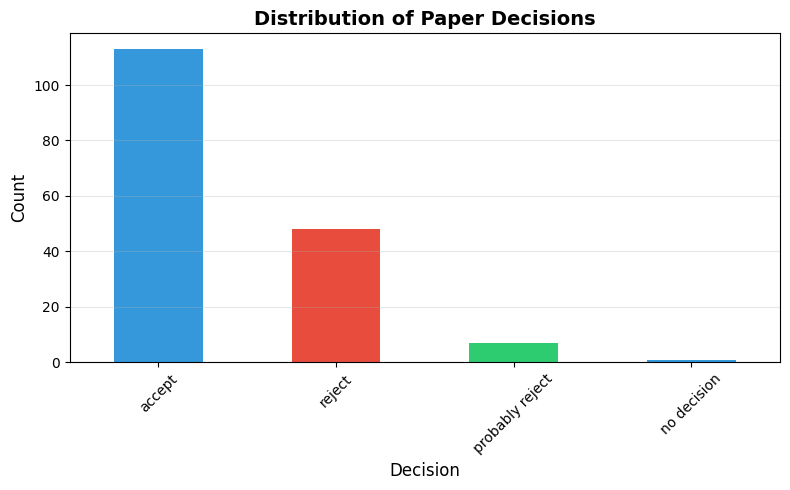


No missing values - data is clean!


In [34]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check class distribution (target variable)
print("\nClass Distribution (Preliminary Decision):")
print(df['decision'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 5))
df['decision'].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c', '#2ecc71'])
plt.title('Distribution of Paper Decisions', fontsize=14, fontweight='bold')
plt.xlabel('Decision', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNo missing values - data is clean!")

In [35]:
# Separate features and target
# Target: decision (accept, reject, etc.)
# Features: all other columns except paper_id and decision

X = df.drop(columns=['paper_id', 'decision'])
y = df['decision']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
print(X.columns.tolist())
print(f"\nTarget classes: {y.unique()}")

Features shape: (169, 12)
Target shape: (169,)

Feature columns:
['num_reviews', 'avg_confidence', 'max_confidence', 'min_confidence', 'std_confidence', 'avg_evaluation', 'max_evaluation', 'min_evaluation', 'std_evaluation', 'avg_orientation', 'positive_orientations', 'negative_orientations']

Target classes: ['accept' 'probably reject' 'reject' 'no decision']


In [36]:
# Encode target variable (decision)
print("Encoding target variable...")
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"Target classes encoded:")
for i, cls in enumerate(le_target.classes_):
    print(f"  {cls} -> {i}")

print(f"\nEncoded target shape: {y_encoded.shape}")
print(f"Class distribution after encoding:")
unique, counts = np.unique(y_encoded, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

Encoding target variable...
Target classes encoded:
  accept -> 0
  no decision -> 1
  probably reject -> 2
  reject -> 3

Encoded target shape: (169,)
Class distribution after encoding:
  Class 0: 113 samples
  Class 1: 1 samples
  Class 2: 7 samples
  Class 3: 48 samples


In [37]:
# Split the data into training and testing sets
# Note: Cannot use stratify due to class with only 1 sample
print("Note: Some classes have very few samples, so stratification is not used.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls} ({le_target.classes_[cls]}): {count} samples")
print(f"\nClass distribution in testing set:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls} ({le_target.classes_[cls]}): {count} samples")

Note: Some classes have very few samples, so stratification is not used.
Training set size: 118 samples
Testing set size: 51 samples

Class distribution in training set:
  Class 0 (accept): 77 samples
  Class 1 (no decision): 1 samples
  Class 2 (probably reject): 5 samples
  Class 3 (reject): 35 samples

Class distribution in testing set:
  Class 0 (accept): 36 samples
  Class 2 (probably reject): 2 samples
  Class 3 (reject): 13 samples


In [38]:
# Normalize the features using StandardScaler
print("Normalizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature normalization completed!")
print(f"\nScaled training data shape: {X_train_scaled.shape}")
print(f"Scaled testing data shape: {X_test_scaled.shape}")

Normalizing features...
Feature normalization completed!

Scaled training data shape: (118, 12)
Scaled testing data shape: (51, 12)


## Step 4: Build BPN (Backpropagation Network) Classifier

Multi-Layer Perceptron with single hidden layer using backpropagation algorithm.

In [39]:
# Calculate optimal number of hidden neurons
# Rule of thumb: (input_features + output_classes) / 2
n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = (n_features + n_classes) // 2

print(f"Number of input features: {n_features}")
print(f"Number of output classes: {n_classes}")
print(f"Number of hidden neurons: {n_hidden}")

# Create MLP classifier with single hidden layer
print("\nBuilding BPN classifier...")
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(n_hidden,),  # Single hidden layer
    activation='relu',                # Activation function
    solver='adam',                    # Optimizer
    max_iter=500,                     # Maximum iterations
    random_state=42,
    learning_rate_init=0.001,         # Initial learning rate
    verbose=True                      # Show training progress
)

# Train the model
print("\nTraining BPN classifier...")
mlp_classifier.fit(X_train_scaled, y_train)
print("\nBPN training completed!")

Number of input features: 12
Number of output classes: 4
Number of hidden neurons: 8

Building BPN classifier...

Training BPN classifier...
Iteration 1, loss = 1.68926941
Iteration 2, loss = 1.68014081
Iteration 3, loss = 1.67104823
Iteration 4, loss = 1.66198984
Iteration 5, loss = 1.65296993
Iteration 6, loss = 1.64400302
Iteration 7, loss = 1.63508398
Iteration 8, loss = 1.62619638
Iteration 9, loss = 1.61735634
Iteration 10, loss = 1.60855104
Iteration 11, loss = 1.59974674
Iteration 12, loss = 1.59096013
Iteration 13, loss = 1.58216122
Iteration 14, loss = 1.57337766
Iteration 15, loss = 1.56462759
Iteration 16, loss = 1.55593939
Iteration 17, loss = 1.54729866
Iteration 18, loss = 1.53870124
Iteration 19, loss = 1.53014785
Iteration 20, loss = 1.52164234
Iteration 21, loss = 1.51321857
Iteration 22, loss = 1.50486654
Iteration 23, loss = 1.49656072
Iteration 24, loss = 1.48830142
Iteration 25, loss = 1.48009102
Iteration 26, loss = 1.47192865
Iteration 27, loss = 1.46381369
Iter

In [40]:
# Make predictions on test set
print("Making predictions on test set...")
y_pred_mlp = mlp_classifier.predict(X_test_scaled)

# Calculate accuracy
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"\nBPN Classifier Accuracy: {mlp_accuracy * 100:.2f}%")

# Display classification report
print("\nBPN Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# Confusion Matrix
mlp_cm = confusion_matrix(y_test, y_pred_mlp)
print("\nBPN Confusion Matrix:")
print(mlp_cm)

Making predictions on test set...

BPN Classifier Accuracy: 92.16%

BPN Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        36
           2       0.00      0.00      0.00         2
           3       0.76      1.00      0.87        13

    accuracy                           0.92        51
   macro avg       0.59      0.65      0.61        51
weighted avg       0.90      0.92      0.91        51


BPN Confusion Matrix:
[[34  0  2]
 [ 0  0  2]
 [ 0  0 13]]


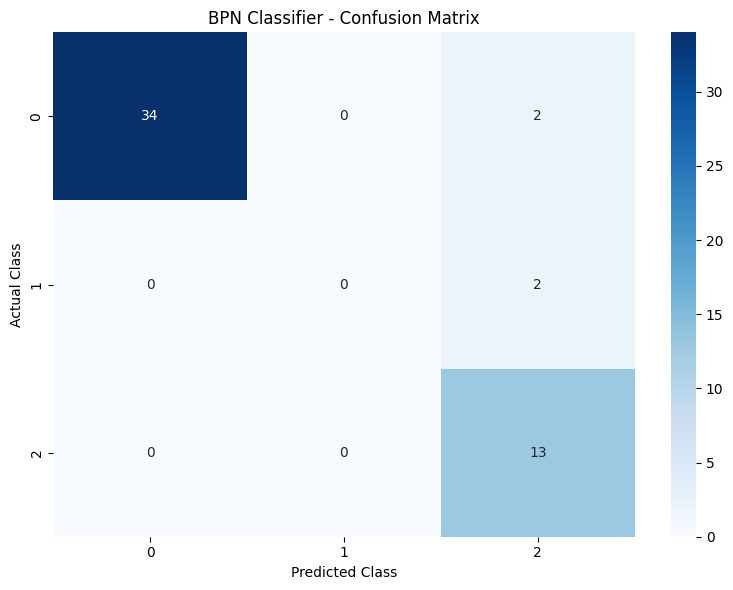

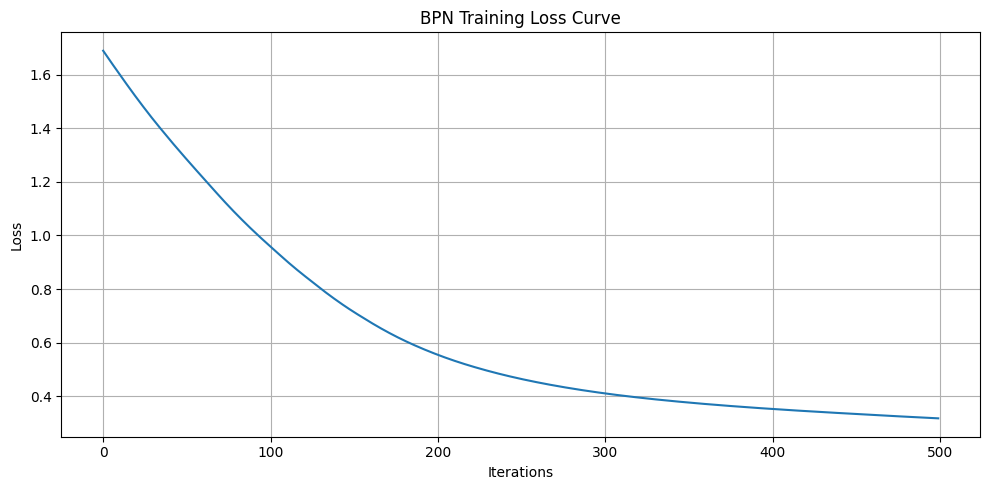

In [41]:
# Visualize BPN Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('BPN Classifier - Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(mlp_classifier.loss_curve_)
plt.title('BPN Training Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 5: Build RBF (Radial Basis Function) Network Classifier

RBF Network with Gaussian activation functions in the hidden layer.

In [42]:
# Implement RBF Network from scratch
class RBFNetwork:
    """
    Radial Basis Function Network with single hidden layer
    """
    def __init__(self, n_centers=10, gamma=1.0):
        """
        Initialize RBF Network
        n_centers: number of RBF centers (hidden neurons)
        gamma: spread parameter for RBF (controls width of Gaussian)
        """
        self.n_centers = n_centers
        self.gamma = gamma
        self.centers = None
        self.weights = None
        
    def _gaussian_rbf(self, X, centers):
        """
        Compute Gaussian RBF activations
        """
        # Calculate Euclidean distances from samples to centers
        distances = cdist(X, centers, metric='euclidean')
        # Apply Gaussian function
        return np.exp(-self.gamma * distances**2)
    
    def fit(self, X, y):
        """
        Train the RBF network
        """
        print(f"Training RBF Network with {self.n_centers} centers...")
        
        # Step 1: Select RBF centers using random sampling from training data
        np.random.seed(42)
        random_indices = np.random.choice(X.shape[0], size=self.n_centers, replace=False)
        self.centers = X[random_indices]
        
        # Step 2: Compute hidden layer activations
        H = self._gaussian_rbf(X, self.centers)
        
        # Add bias term
        H = np.column_stack([np.ones(H.shape[0]), H])
        
        # Step 3: Solve for output weights using pseudo-inverse (least squares)
        # Convert y to one-hot encoding if needed
        y_unique = np.unique(y)
        n_classes = len(y_unique)
        
        if n_classes > 2:
            # Multi-class: one-hot encoding
            y_encoded = np.zeros((y.shape[0], n_classes))
            for i, label in enumerate(y):
                y_encoded[i, label] = 1
        else:
            # Binary: use single output
            y_encoded = y.reshape(-1, 1)
        
        # Compute weights: W = (H^T H)^(-1) H^T Y
        self.weights = np.linalg.pinv(H) @ y_encoded
        
        print("RBF Network training completed!")
        
        return self
    
    def predict(self, X):
        """
        Make predictions
        """
        # Compute hidden layer activations
        H = self._gaussian_rbf(X, self.centers)
        
        # Add bias term
        H = np.column_stack([np.ones(H.shape[0]), H])
        
        # Compute output
        output = H @ self.weights
        
        # For multi-class, take argmax
        if output.shape[1] > 1:
            predictions = np.argmax(output, axis=1)
        else:
            predictions = (output > 0.5).astype(int).flatten()
        
        return predictions

print("RBF Network class defined successfully!")

RBF Network class defined successfully!


In [43]:
# Create and train RBF classifier
# Number of centers: similar to hidden neurons in MLP
n_rbf_centers = n_hidden

print(f"Creating RBF Network with {n_rbf_centers} centers...")
rbf_classifier = RBFNetwork(n_centers=n_rbf_centers, gamma=0.5)

# Train the RBF network
rbf_classifier.fit(X_train_scaled, y_train)

Creating RBF Network with 8 centers...
Training RBF Network with 8 centers...
RBF Network training completed!


In [44]:
# Make predictions on test set
print("Making predictions on test set...")
y_pred_rbf = rbf_classifier.predict(X_test_scaled)

# Calculate accuracy
rbf_accuracy = accuracy_score(y_test, y_pred_rbf)
print(f"\nRBF Classifier Accuracy: {rbf_accuracy * 100:.2f}%")

# Display classification report
print("\nRBF Classification Report:")
print(classification_report(y_test, y_pred_rbf))

# Confusion Matrix
rbf_cm = confusion_matrix(y_test, y_pred_rbf)
print("\nRBF Confusion Matrix:")
print(rbf_cm)

Making predictions on test set...

RBF Classifier Accuracy: 70.59%

RBF Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        36
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        13

    accuracy                           0.71        51
   macro avg       0.24      0.33      0.28        51
weighted avg       0.50      0.71      0.58        51


RBF Confusion Matrix:
[[36  0  0]
 [ 2  0  0]
 [13  0  0]]


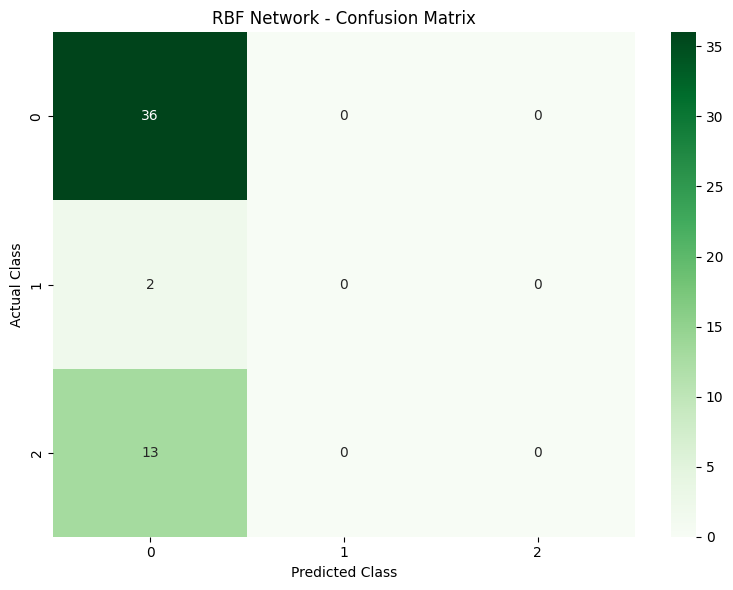

In [45]:
# Visualize RBF Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rbf_cm, annot=True, fmt='d', cmap='Greens', cbar=True)
plt.title('RBF Network - Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()

## Step 6: Compare BPN and RBF Classifiers

Let's compare the performance of both classifiers.

In [46]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Classifier': ['BPN (MLP)', 'RBF Network'],
    'Accuracy (%)': [mlp_accuracy * 100, rbf_accuracy * 100],
    'Hidden Units/Centers': [n_hidden, n_rbf_centers]
})

print("=" * 60)
print("COMPARISON OF BPN AND RBF CLASSIFIERS")
print("=" * 60)
print(comparison_df.to_string(index=False))
print("=" * 60)

# Determine which performed better
if mlp_accuracy > rbf_accuracy:
    print(f"\n✓ BPN classifier performed better by {(mlp_accuracy - rbf_accuracy) * 100:.2f}%")
elif rbf_accuracy > mlp_accuracy:
    print(f"\n✓ RBF classifier performed better by {(rbf_accuracy - mlp_accuracy) * 100:.2f}%")
else:
    print(f"\n✓ Both classifiers achieved the same accuracy!")

COMPARISON OF BPN AND RBF CLASSIFIERS
 Classifier  Accuracy (%)  Hidden Units/Centers
  BPN (MLP)     92.156863                     8
RBF Network     70.588235                     8

✓ BPN classifier performed better by 21.57%


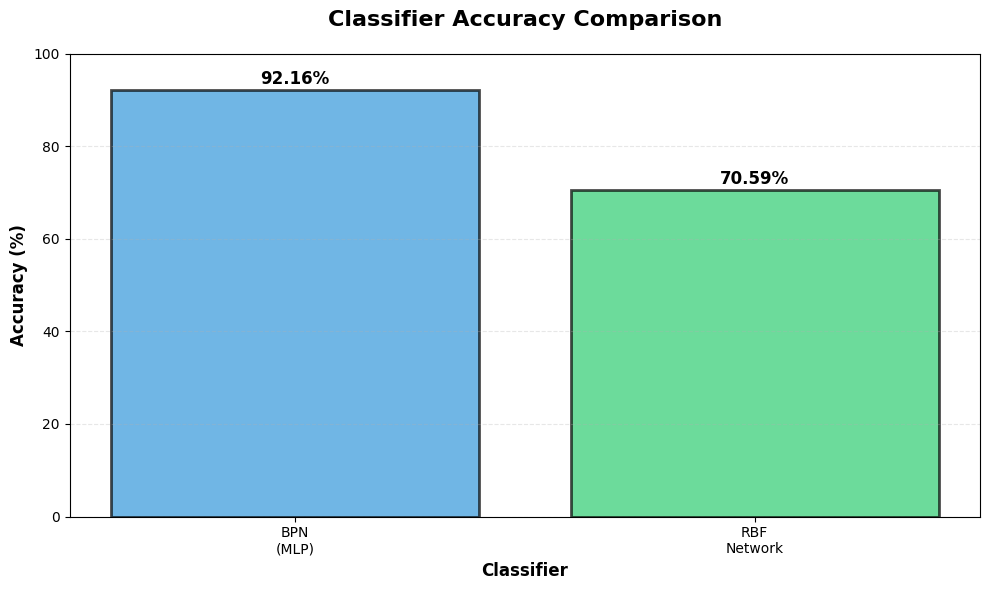

In [47]:
# Visualize accuracy comparison
plt.figure(figsize=(10, 6))
classifiers = ['BPN\n(MLP)', 'RBF\nNetwork']
accuracies = [mlp_accuracy * 100, rbf_accuracy * 100]
colors = ['#3498db', '#2ecc71']

bars = plt.bar(classifiers, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Classifier Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.xlabel('Classifier', fontsize=12, fontweight='bold')
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

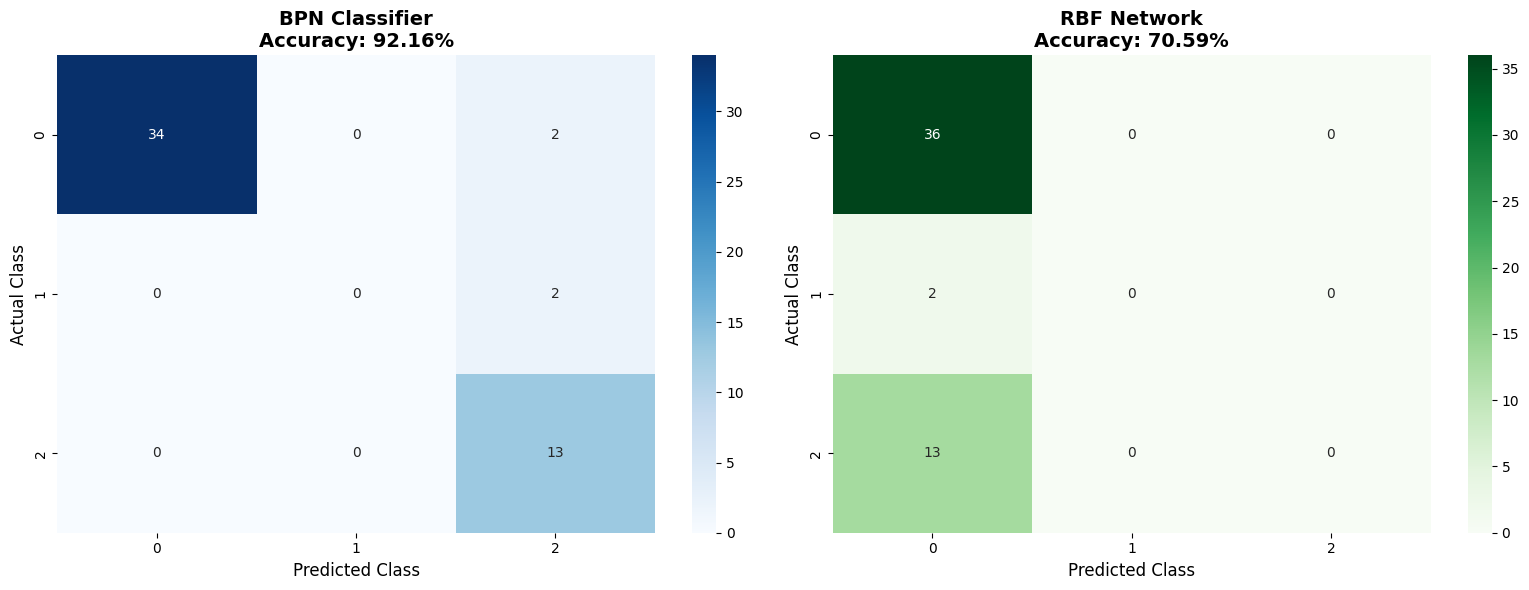

In [48]:
# Side-by-side confusion matrix comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BPN Confusion Matrix
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[0])
axes[0].set_title(f'BPN Classifier\nAccuracy: {mlp_accuracy * 100:.2f}%', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual Class', fontsize=12)
axes[0].set_xlabel('Predicted Class', fontsize=12)

# RBF Confusion Matrix
sns.heatmap(rbf_cm, annot=True, fmt='d', cmap='Greens', cbar=True, ax=axes[1])
axes[1].set_title(f'RBF Network\nAccuracy: {rbf_accuracy * 100:.2f}%', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual Class', fontsize=12)
axes[1].set_xlabel('Predicted Class', fontsize=12)

plt.tight_layout()
plt.show()